In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
from model_mnist import LeNet5, LinAutoencoder, ConvAutoencoder
from visualize import *
import autoencoder 
import dset_mnist as dset
import foolbox
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# set args
args = dset.get_args()
args.cuda = True

# load mnist data
train_loader, test_loader = dset.load_data(args.batch_size, args.test_batch_size, device)

# load model
m = LeNet5().eval()
m.load_state_dict(torch.load('weights/lenet_epoch=12_test_acc=0.991.pth'))
m = m.to(device)

# test model
dset.test(m, test_loader, args)


Test set: Average loss: 0.0306, Accuracy: 9907/10000 (99.07%)



# autoencoder

In [14]:
lamb_grid = np.geomspace(1e-6, 0.5, 20)
Losses = []
tLosses = []

# number of epochs to train the model
num_epochs = 20

for i,lamb in enumerate(lamb_grid):
    print(i)
    # initialize the NN
    model = LinAutoencoder().to(device)

    # prepend model
    m_t = TrimModel(m, model.i_transformer, use_residuals=True)

    losses = []
    tlosses = []
    num_delay = 0
    
    best_loss = 1e+10

    # actually do training
    for epoch in range(1, num_epochs + 1):
        model, train_loss = autoencoder.train(epoch, train_loader, model, m_t, lamb)
        test_loss = autoencoder.test(test_loader, model, m_t, lamb)

        # print avg training statistics 
        train_loss = train_loss/len(train_loader.dataset)
        test_loss = test_loss/len(test_loader.dataset)
        print('\nEpoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss))
        losses.append(train_loss)
        tlosses.append(test_loss)
        if test_loss <= best_loss:
            best_loss = test_loss
            num_delay = 0
        else:
            num_delay += 1

#         if num_delay == 3:
#             break
            
    torch.save(model.state_dict(), 'results/autoencoder_lin_layer_supervised/transform_' + str(np.around(lamb, 6)))              
    Losses.append(losses)
    tLosses.append(tlosses)
    

0
Train Epoch: 1 [29984/60000 (100%)]	Loss: 1.063028
Epoch: 1 	Training Loss: 1.853611
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.632077
Epoch: 2 	Training Loss: 0.816444
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.610065
Epoch: 3 	Training Loss: 0.570421
Train Epoch: 4 [29984/60000 (100%)]	Loss: 0.261813
Epoch: 4 	Training Loss: 0.466274
Train Epoch: 5 [29984/60000 (100%)]	Loss: 0.290629
Epoch: 5 	Training Loss: 0.408070
Train Epoch: 6 [29984/60000 (100%)]	Loss: 0.438837
Epoch: 6 	Training Loss: 0.368066
Train Epoch: 7 [29984/60000 (100%)]	Loss: 0.303418
Epoch: 7 	Training Loss: 0.338755
Train Epoch: 8 [29984/60000 (100%)]	Loss: 0.186433
Epoch: 8 	Training Loss: 0.315991
Train Epoch: 9 [29984/60000 (100%)]	Loss: 0.166193
Epoch: 9 	Training Loss: 0.297044
Train Epoch: 10 [29984/60000 (100%)]	Loss: 0.211329
Epoch: 10 	Training Loss: 0.281635
Train Epoch: 11 [29984/60000 (100%)]	Loss: 0.206240
Epoch: 11 	Training Loss: 0.268958
Train Epoch: 12 [29984/60000 (100%)]	Loss: 0.371056
Epoch: 

49.50539


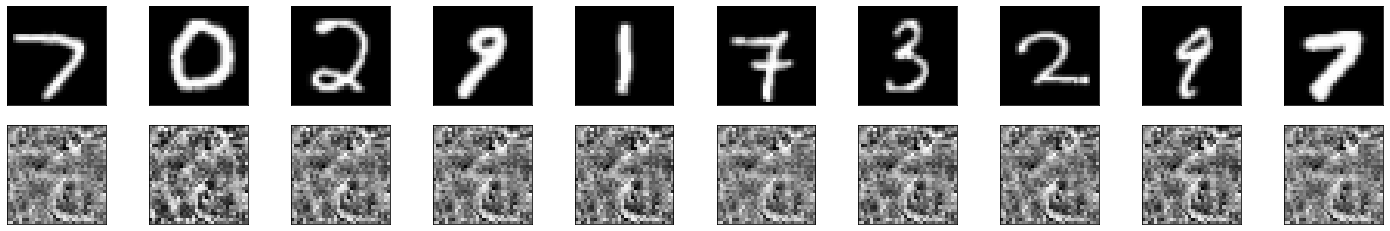

In [15]:
# load model
model.load_state_dict(torch.load('results/autoencoder_lin_layer_supervised/transform_' + str(np.around(lamb, 6))))

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[70:80]
model = model.to('cpu')

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(10, 1, 32, 32)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

print(np.linalg.norm(output - images))

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# visualization

In [46]:
# load model
lamb = lamb_grid[-1]
model.load_state_dict(torch.load('results/autoencoder_lin_layer_supervised/transform_' + str(np.around(lamb, 6))))

<All keys matched successfully>

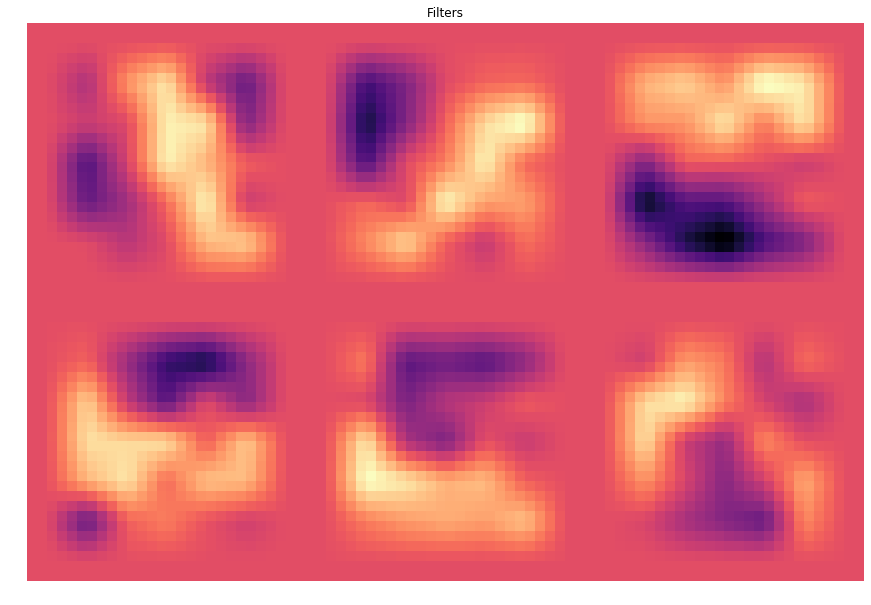

In [47]:
# viz filters
viz_tensors(m.convnet.c1.weight.squeeze(), n_row=2, n_col=3, normalize=False)

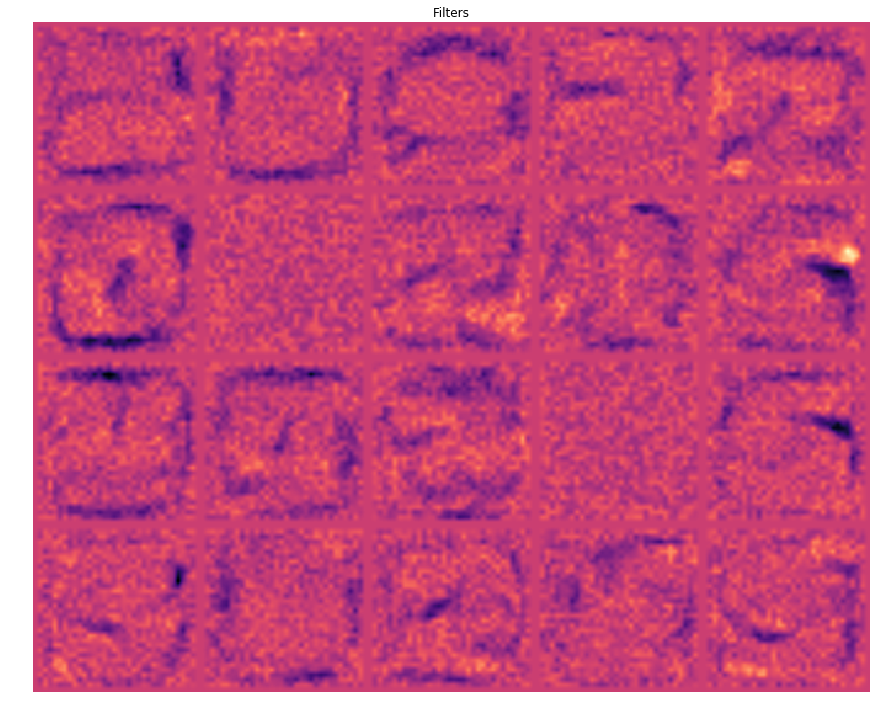

In [48]:
# viz filters
viz_tensors(model.fc1.weight.view(-1, 32, 32), n_row=4, n_col=5, normalize=False)

In [49]:
# data
inputs, labels = iter(test_loader).next()
inputs = inputs.to(device)
labels = labels.to(device)

# get attributions
model = model.to(device)
m_t = TrimModel(m, model.i_transformer, use_residuals=True)

s = model.transformer(inputs)
attributer = InputXGradient(m_t)
# attributer = IntegratedGradients(m_t)        
attributions = attributer.attribute(s, target=labels, additional_forward_args=deepcopy(inputs))
# standardization
mean = attributions.mean(dim=1, keepdim=True)
std = attributions.std(dim=1, keepdim=True)
attributions = (attributions - mean) / std   

In [50]:
attributions.shape

torch.Size([1000, 20])

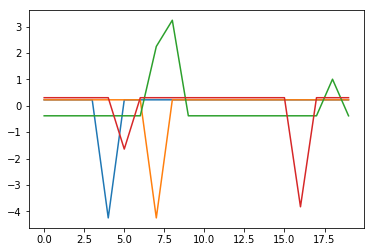

In [51]:
plt.plot(attributions[0].detach().cpu().numpy())
plt.plot(attributions[1].detach().cpu().numpy())
plt.plot(attributions[2].detach().cpu().numpy())
plt.plot(attributions[3].detach().cpu().numpy())